In [1]:
# Forces the notebook to always reload packages.
%reload_ext autoreload
%autoreload 2

## Dataset loading

### Regular dataset loading

In [2]:
from python_proj.utils.util import Counter
import python_proj.utils.exp_utils as exp_utils

# Defines a number of constants.

file_name = "dataset_transformed"
base_path = exp_utils.BASE_PATH
data_path = f"{base_path}/final_data/{file_name}.csv"
figure_base_path = f"{base_path}/figures/modelling/{file_name}/rf_full/"

# Meta stuff.
pr_merged_key = "PullRequestIsMerged"
ftc_key = "SubmitterIsFirstTimeContributor"
seed_counter = Counter()

In [3]:
import pandas as pd
import numpy as np
import json


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)

# Creates sub-datasets.
metadata_fields = ["ID", "Project Name", "Submitter ID", "PR Number", "Closed At"]
dependent_fields = [pr_merged_key]

df.describe()

,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality),ln(1 + EcosystemLinkIntensity),ln(1 + IntraProjectLinkIntensity)
count,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,...,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,1.473092e+08,5.092504e+06,8.089130e+02,5.029367e-01,4.028501e-01,9.853429e-02,3.751776e-01,5.922709e-02,4.195426e-01,1.183858e-01,...,1.144450e-02,1.968795e-02,7.962418e-02,1.344287e-01,9.542167e-03,1.752697e-02,6.396780e-02,6.040052e-02,2.195312e-02,4.472791e-02
std,9.954409e+07,7.968202e+06,2.304617e+03,4.710606e-01,4.523397e-01,2.907111e-01,4.479337e-01,2.285036e-01,2.256901e-01,7.147764e-02,...,5.396848e-02,8.007560e-02,1.179799e-01,1.750052e-01,5.263118e-02,8.245257e-02,9.934566e-02,1.002992e-01,8.741610e-02,1.013945e-01
min,6.870000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.924867e+07,4.674710e+05,5.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.365158e-01,7.525668e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.366714e+08,1.633887e+06,1.990000e+02,6.800000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.433349e-01,7.525668e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,7.753347e-02,0.000000e+00,0.000000e+00,8.453635e-03,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.260994e+08,6.254382e+06,6.840000e+02,1.000000e+00,9.391304e-01,0.000000e+00,9.230769e-01,0.000000e+00,5.863557e-01,1.505134e-01,...,0.000000e+00,0.000000e+00,1.416667e-01,2.326004e-01,0.000000e+00,0.000000e+00,9.892883e-02,8.837267e-02,0.000000e+00,2.582313e-02
max,3.617756e+08,5.973444e+07,8.297600e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [4]:
print(list(df.columns))

['ID', 'Project Name', 'Submitter ID', 'PR Number', 'Closed At', 'PullRequestIsMerged', 'ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'SubmitterIsFirstTimeContributor', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystem

In [ ]:
intra_collab_fields = [
    "ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality)",
    "ln(1 + IntraProjectLinkIntensity)",
]

df = df.drop(intra_collab_fields, axis=1)

In [5]:
# Identifieds independent / predictor fields.


def is_independent_field(field: str) -> bool:
    return field not in metadata_fields and field != pr_merged_key


independent_fields = list(filter(is_independent_field, df.columns))

In [6]:
# Calculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f"{class_imbalance=}")

class_imbalance=3.6991542286634957


## Model Creation

In [7]:
k = 5
print(f"Using {k=} folds.")

Using k=5 folds.


Generates a number of feature groups that are relevant later in the pipeline:
- control variables
- intra-project experience
- ecosystem experience
- dependency ecosystem experience
- inverse dependency ecosystem experience
- non-dependency ecosystem experience
- collaboration variables

In [8]:
from enum import Enum
from python_proj.utils.util import get_matching

# Defines feature groups


class FeatureGroups(Enum):
    Control = 1
    Intra = 2
    Eco = 3
    DEco = 4
    IDEco = 5
    NDEco = 6
    Coll = 7


var_group_regex_patterns = [
    (FeatureGroups.Control, r".*Control.*"),
    (
        FeatureGroups.Intra,
        r"^(?:(?!Control|Degree|Link).)*Intra(?:(?!Control|Degree|Link).)*$",
    ),
    (FeatureGroups.Eco, r"^(?:(?!Dependency).)*Ecosystem(?:(?!Degree|Link).)*$"),
    (FeatureGroups.DEco, r"^(?!.*(Inverse|Non)).*(?=Dependency).*"),
    (FeatureGroups.IDEco, r".*(?=Inverse).*"),
    (FeatureGroups.NDEco, r".*(?=NonDependency).*"),
    (FeatureGroups.Coll, r"^(?:(?!Intra).)*(Weighted|LinkIntensity)(?:(?!Intra).)*$"),
]

# Resolves the regex patterns to generate lists of fields.
var_groups = {
    str(name): list(get_matching(independent_fields, pattern))
    for name, pattern in var_group_regex_patterns
}


print("Feature groups:")
print(json.dumps(var_groups, indent=2))

Feature groups:
{
  "FeatureGroups.Control": [
    "ControlIntegratedBySameUser",
    "ControlPullRequestHasComments",
    "ControlPullRequestHasCommentByExternalUser",
    "ControlHasHashTagInDescription",
    "ln(1 + ControlPullRequestLifeTimeInMinutes)",
    "ln(1 + ControlNumberOfCommitsInPullRequest)",
    "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)"
  ],
  "FeatureGroups.Intra": [
    "IntraProjectSubmitterPullRequestSuccessRate",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    "ln(1 + IntraProjectSubmitterIssueSubmissionCount)",
    "ln(1 + IntraProjectSubmitterIssueCommentCount)"
  ],
  "FeatureGroups.Eco": [
    "EcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)",
    "ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + Ecosyst

In [9]:
from wmutils.collections.list_access import flatten


def get_feature_groups(*feature_groups) -> list[str]:
    return list(flatten(var_groups[str(group)] for group in feature_groups))

### Full Model

In [10]:
from python_proj.modelling.notebooks.random_forest.rf_functions import (
    kfold_rf_evaluation,
)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, independent_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics full model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

random_state=43

random_state=43

random_state=43

random_state=43

random_state=43

metrics={'accuracy': 0.8749691667625923, 'precision': 0.8994257287398238, 'recall': 0.9472181926340287, 'f1': 0.922703509133099}


Confusion matrix:
[[ 31308  20298]
 [ 10115 181523]]


Classification report:

              precision    recall  f1-score   support

       False       0.76      0.61      0.67     51606
        True       0.90      0.95      0.92    191638

    accuracy                           0.87    243244
   macro avg       0.83      0.78      0.80    243244
weighted avg       0.87      0.87      0.87    243244


metrics={'accuracy': 0.8734650249748196, 'precision': 0.8971733159444346, 'recall': 0.9479895812127761, 'f1': 0.9218817020088578}


Confusion matrix:
[[ 30853  20815]
 [  9964 181613]]


Classification report:

              precision    recall  f1-score   support

       False       0.76      0.60      0.67     51668
        True       0.90      0.95      0.92    191577

    accuracy                           0.87    243245
   macro avg       0.83      0.77      0.79    243245
weighted avg       0.87      0.87      0.87    243245


metrics={'accuracy': 0.8715733995494236, 'precision': 0.8962530885899195, 'recall': 0.9462224499184476, 'f1': 0.9205601653947579}


Confusion matrix:
[[ 31004  20952]
 [ 10287 181001]]


Classification report:

              precision    recall  f1-score   support

       False       0.75      0.60      0.66     51956
        True       0.90      0.95      0.92    191288

    accuracy                           0.87    243244
   macro avg       0.82      0.77      0.79    243244
weighted avg       0.87      0.87      0.87    243244


metrics={'accuracy': 0.8740400585420401, 'precision': 0.8974063770808525, 'recall': 0.9484265825561115, 'f1': 0.9222113614725486}


Confusion matrix:
[[ 30987  20763]
 [  9876 181618]]


Classification report:

              precision    recall  f1-score   support

       False       0.76      0.60      0.67     51750
        True       0.90      0.95      0.92    191494

    accuracy                           0.87    243244
   macro avg       0.83      0.77      0.80    243244
weighted avg       0.87      0.87      0.87    243244


metrics={'accuracy': 0.8728807288155104, 'precision': 0.8965045262284065, 'recall': 0.947880694018505, 'f1': 0.9214770571609237}


Confusion matrix:
[[ 30892  20945]
 [  9976 181431]]


Classification report:

              precision    recall  f1-score   support

       False       0.76      0.60      0.67     51837
        True       0.90      0.95      0.92    191407

    accuracy                           0.87    243244
   macro avg       0.83      0.77      0.79    243244
weighted avg       0.87      0.87      0.87    243244



Performance metrics full model:
f1_scores=[0.922703509133099, 0.9218817020088578, 0.9205601653947579, 0.9222113614725486, 0.9214770571609237]
f1_mean=0.9217667590340375, f1_std=0.0007250074964464491


### Control + Intra-project Model

In [11]:
contr_with_intra = get_feature_groups(FeatureGroups.Control, FeatureGroups.Intra)
print(contr_with_intra)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, contr_with_intra, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics control + intra model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']


random_state=45

random_state=45

random_state=45

random_state=45

random_state=45

metrics={'accuracy': 0.8552077123887438, 'precision': 0.8908728274290056, 'recall': 0.9301233240609783, 'f1': 0.9100750651074913}


Confusion matrix:
[[ 29805  21831]
 [ 13389 178220]]


Classification report:

              precision    recall  f1-score   support

       False       0.69      0.58      0.63     51636
        True       0.89      0.93      0.91    191609

    accuracy                           0.86    243245
   macro avg       0.79      0.75      0.77    243245
weighted avg       0.85      0.86      0.85    243245


metrics={'accuracy': 0.8556634490470474, 'precision': 0.8897133305057259, 'recall': 0.9320108724060425, 'f1': 0.9103710605925226}


Confusion matrix:
[[ 29832  22102]
 [ 13007 178303]]


Classification report:

metrics={'accuracy': 0.8545000082221966, 'precision': 0.8896731203420648, 'recall': 0.9304909776714347, 'f1': 0.9096243711856183}


Confusion matrix:
[[ 29743  22087]
 [ 13305 178109]]


Classification report:

metrics={'accuracy': 0.8553962276561806, 'precision': 0.891045037385281, 'recall': 0.9301014361860411, 'f1': 0.9101544340398575}


Confusion matrix:
[[ 29910  21785]
 [ 13389 178160]]


Classification report:

metrics={'accuracy': 0.8551207840686718, 'precision': 0.8905599456198487, 'recall': 0.9303213207882123, 'f1': 0.9100065118298243}


Confusion matrix:
[[ 29826  21896]
 [ 13345 178177]]


Classification report:

              precision    recall  f1-score   support

       False       0.70      0.57      0.63     51934
        True       0.89      0.93      0.91    191310

    accuracy                           0.86    243244
   macro avg       0.79      0.75      0.77    243244
weighted avg       0.85      0.86      0.85    243244


              precision    recall  f1-score   support

       False       0.69      0.57      0.63     51830
        True       0.89      0.93      0.91    191414

    accuracy                           0.85    243244
   macro avg       0.79      0.75      0.77    243244
weighted avg       0.85      0.85      0.85    243244


              precision    recall  f1-score   support

       False       0.69      0.58      0.63     51695
        True       0.89      0.93      0.91    191549

    accuracy                           0.86    243244
   macro avg       0.79      0.75      0.77    243244
weighted avg       0.85      0.86      0.85    243244


              precision    recall  f1-score   support

       False       0.69      0.58      0.63     51722
        True       0.89      0.93      0.91    191522

    accuracy                           0.86    243244
   macro avg       0.79      0.75      0.77    243244
weighted avg       0.85      0.86      0.85    243244



Performance metrics control + intra model:
f1_scores=[0.9100750651074913, 0.9103710605925226, 0.9096243711856183, 0.9101544340398575, 0.9100065118298243]
f1_mean=0.9100462885510627, f1_std=0.00024396592658671497


### Collaboration and Ecosystem Model

In [12]:
non_control_intra_fields = get_feature_groups(
    FeatureGroups.Eco,
    FeatureGroups.DEco,
    FeatureGroups.IDEco,
    FeatureGroups.NDEco,
    FeatureGroups.Coll,
)
print(non_control_intra_fields)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, non_control_intra_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics non-control model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosyste

random_state=47

random_state=47

random_state=47

random_state=47

random_state=47

metrics={'accuracy': 0.7801352545787169, 'precision': 0.7962613933479592, 'recall': 0.9685313224573351, 'f1': 0.8739883085579376}


Confusion matrix:
[[  4298  47455]
 [  6026 185466]]


Classification report:

              precision    recall  f1-score   support

       False       0.42      0.08      0.14     51753
        True       0.80      0.97      0.87    191492

    accuracy                           0.78    243245
   macro avg       0.61      0.53      0.51    243245
weighted avg       0.72      0.78      0.72    243245


metrics={'accuracy': 0.7823954547696963, 'precision': 0.7979528336301797, 'recall': 0.9694806549170925, 'f1': 0.8753934343256001}


Confusion matrix:
[[  4386  47078]
 [  5853 185927]]


Classification report:

              precision    recall  f1-score   support

       False       0.43      0.09      0.14     51464
        True       0.80      0.97      0.88    191780

    accuracy                           0.78    243244
   macro avg       0.61      0.53      0.51    243244
weighted avg       0.72      0.78      0.72    243244


metrics={'accuracy': 0.7807962375228166, 'precision': 0.79643470790378, 'recall': 0.9690080485000523, 'f1': 0.8742867920969492}


Confusion matrix:
[[  4514  47390]
 [  5930 185410]]


Classification report:

              precision    recall  f1-score   support

       False       0.43      0.09      0.14     51904
        True       0.80      0.97      0.87    191340

    accuracy                           0.78    243244
   macro avg       0.61      0.53      0.51    243244
weighted avg       0.72      0.78      0.72    243244


metrics={'accuracy': 0.7812196806498825, 'precision': 0.7968028388660002, 'recall': 0.9690736193113538, 'f1': 0.8745352568258601}


Confusion matrix:
[[  4556  47298]
 [  5919 185471]]


Classification report:

              precision    recall  f1-score   support

       False       0.43      0.09      0.15     51854
        True       0.80      0.97      0.87    191390

    accuracy                           0.78    243244
   macro avg       0.62      0.53      0.51    243244
weighted avg       0.72      0.78      0.72    243244


metrics={'accuracy': 0.7803481278058246, 'precision': 0.7964394522101952, 'recall': 0.9683545626482482, 'f1': 0.8740235641411961}


Confusion matrix:
[[  4470  47372]
 [  6057 185345]]


Classification report:

              precision    recall  f1-score   support

       False       0.42      0.09      0.14     51842
        True       0.80      0.97      0.87    191402

    accuracy                           0.78    243244
   macro avg       0.61      0.53      0.51    243244
weighted avg       0.72      0.78      0.72    243244



Performance metrics non-control model:
f1_scores=[0.8739883085579376, 0.8753934343256001, 0.8742867920969492, 0.8745352568258601, 0.8740235641411961]
f1_mean=0.8744454711895087, f1_std=0.0005135908588399307


## Feature Explanation and Evaluation

### Model Creation

In [13]:
from sklearn.model_selection import train_test_split

from python_proj.modelling.notebooks.random_forest.rf_functions import create_model


train, test = train_test_split(df, test_size=0.2, shuffle=True)
train_predictors = train[independent_fields]
train_dependent = train[pr_merged_key]
test_predictors = test[independent_fields]
test_dependent = test[pr_merged_key]


full_rf_model, _ = create_model(
    train_predictors, train_dependent, test_predictors, test_dependent, seed_counter
)

random_state=49


metrics={'accuracy': 0.8736623568829781, 'precision': 0.8978999792077149, 'recall': 0.9472166951290206, 'f1': 0.9218992627306667}

Confusion matrix:
[[ 31140  20624]
 [ 10107 181374]]

Classification report:


              precision    recall  f1-score   support

       False       0.75      0.60      0.67     51764
        True       0.90      0.95      0.92    191481

    accuracy                           0.87    243245
   macro avg       0.83      0.77      0.80    243245
weighted avg       0.87      0.87      0.87    243245



### Mean decrease in Impurity

/tmp/ipykernel_16900/1648129876.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


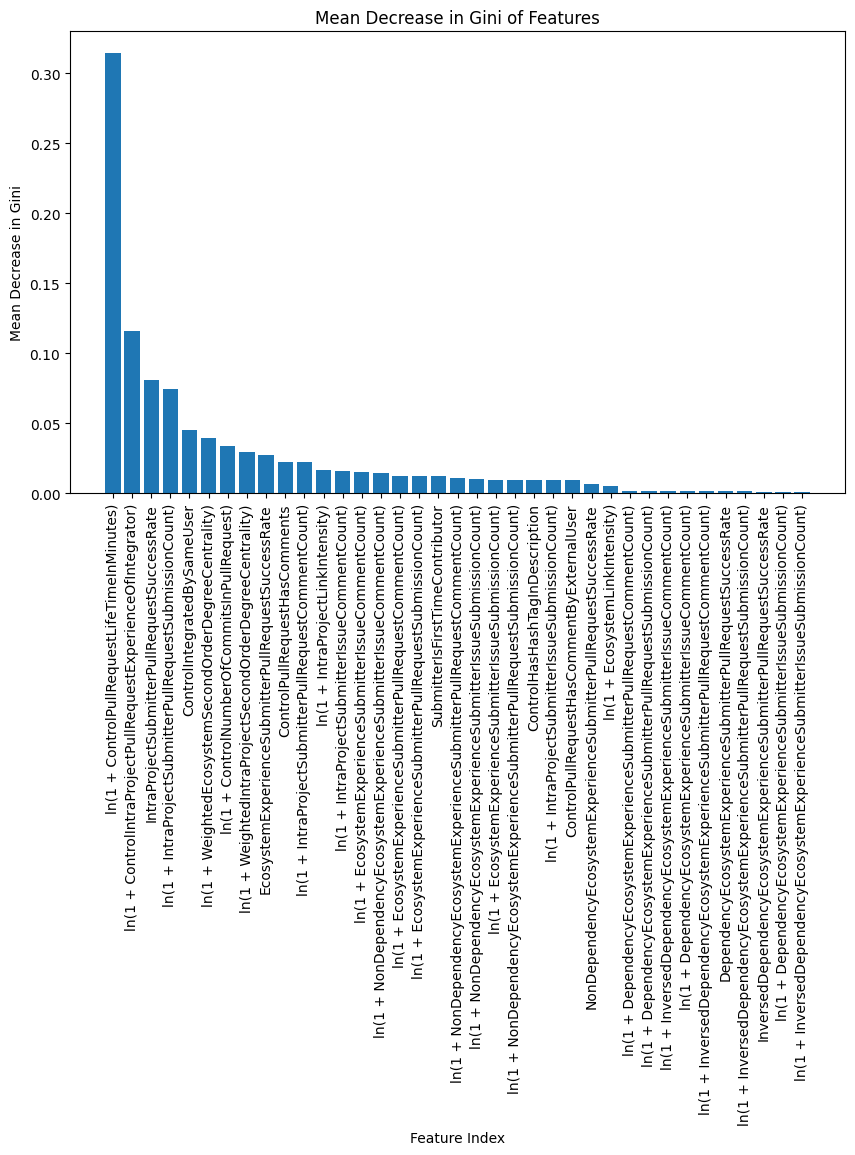

In [14]:
from matplotlib import pyplot as plt

feature_importances = full_rf_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

# Step 4: Plot the mean decrease accuracy plot
plt.figure(figsize=(10, 6))
plt.bar(range(test_predictors.shape[1]), sorted_importances)
plt.xlabel("Feature Index")
plt.ylabel("Mean Decrease in Gini")
plt.title("Mean Decrease in Gini of Features")
ordererd_columns = np.array(test_predictors.columns)[sorted_indices]
plt.xticks(range(test_predictors.shape[1]), ordererd_columns, rotation=90)
plt.tight_layout()
plt.show()

In [15]:
# Stores feature importances in file.
output_file = f"{figure_base_path}/feature_importance.txt"
with open(output_file, "w+", encoding="utf-8") as output_file:
    for field, importance in zip(ordererd_columns, sorted_importances):
        entry = f"{field}: {importance}"
        output_file.write(f'{entry}\n')
        print(entry)

ln(1 + ControlPullRequestLifeTimeInMinutes): 0.3141301050826137
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator): 0.11576323475001665
IntraProjectSubmitterPullRequestSuccessRate: 0.08067274527656629
ln(1 + IntraProjectSubmitterPullRequestSubmissionCount): 0.07426043020148054
ControlIntegratedBySameUser: 0.045420011074970255
ln(1 + WeightedEcosystemSecondOrderDegreeCentrality): 0.03936259526769938
ln(1 + ControlNumberOfCommitsInPullRequest): 0.033538293232779015
ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality): 0.029636231708714326
EcosystemExperienceSubmitterPullRequestSuccessRate: 0.027729276329130775
ControlPullRequestHasComments: 0.02272738376267443
ln(1 + IntraProjectSubmitterPullRequestCommentCount): 0.022176750971998345
ln(1 + IntraProjectLinkIntensity): 0.016732116318174114
ln(1 + IntraProjectSubmitterIssueCommentCount): 0.016290966023646936
ln(1 + EcosystemExperienceSubmitterIssueCommentCount): 0.015248218273812788
ln(1 + NonDependencyEcosystemExperienceSubmi

### Variable Group Reverse Ablation Studies

Creates a model with a subset of features.
Compared to regular ablation, it tests "what happens if I add a feature", instead of "what happens when I remove one".

In [16]:
rev_abl_results = dict()

for cluster_name, cluster in var_groups.items():
    print(f'Reverse ablation with "{str(cluster_name)}", including: {cluster}.')

    # Creates models
    f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
        df, cluster, k, pr_merged_key, seed_counter
    )
    rev_abl_results[cluster_name] = (f1_scores, f1_mean, f1_std)

    print(
        f"Performance of '{cluster_name}'\n{list(cluster)}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n"
    )

Reverse ablation with "FeatureGroups.Control", including: ['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)'].


random_state=50

random_state=50

random_state=50

random_state=50

random_state=50

metrics={'accuracy': 0.7995642253694835, 'precision': 0.8517131568083978, 'recall': 0.9031689865600784, 'f1': 0.8766866898514071}


Confusion matrix:
[[ 21180  30174]
 [ 18581 173310]]


Classification report:

              precision    recall  f1-score   support

       False       0.53      0.41      0.46     51354
        True       0.85      0.90      0.88    191891

    accuracy                           0.80    243245
   macro avg       0.69      0.66      0.67    243245
weighted avg       0.78      0.80      0.79    243245


metrics={'accuracy': 0.798831625857164, 'precision': 0.8494723880633624, 'recall': 0.9046591574019894, 'f1': 0.8761976566789205}


Confusion matrix:
[[ 21152  30684]
 [ 18249 173159]]


Classification report:

              precision    recall  f1-score   support

       False       0.54      0.41      0.46     51836
        True       0.85      0.90      0.88    191408

    accuracy                           0.80    243244
   macro avg       0.69      0.66      0.67    243244
weighted avg       0.78      0.80      0.79    243244


metrics={'accuracy': 0.7988891812336584, 'precision': 0.8499997543637283, 'recall': 0.9039424051492638, 'f1': 0.8761415741887133}


Confusion matrix:
[[ 21305  30533]
 [ 18386 173020]]


Classification report:

              precision    recall  f1-score   support

       False       0.54      0.41      0.47     51838
        True       0.85      0.90      0.88    191406

    accuracy                           0.80    243244
   macro avg       0.69      0.66      0.67    243244
weighted avg       0.78      0.80      0.79    243244


metrics={'accuracy': 0.7977586291953759, 'precision': 0.8484619350403849, 'recall': 0.9040929614456948, 'f1': 0.8753945055446076}


Confusion matrix:
[[ 21248  30863]
 [ 18331 172802]]


Classification report:

              precision    recall  f1-score   support

       False       0.54      0.41      0.46     52111
        True       0.85      0.90      0.88    191133

    accuracy                           0.80    243244
   macro avg       0.69      0.66      0.67    243244
weighted avg       0.78      0.80      0.79    243244


metrics={'accuracy': 0.8008255085428623, 'precision': 0.8507312721783284, 'recall': 0.9060741467692597, 'f1': 0.8775310040091608}


Confusion matrix:
[[ 21223  30455]
 [ 17993 173573]]


Classification report:

              precision    recall  f1-score   support

       False       0.54      0.41      0.47     51678
        True       0.85      0.91      0.88    191566

    accuracy                           0.80    243244
   macro avg       0.70      0.66      0.67    243244
weighted avg       0.78      0.80      0.79    243244


Performance of 'FeatureGroups.Control'
['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)']
f1_scores=[0.8766866898514071, 0.8761976566789205, 0.8761415741887133, 0.8753945055446076, 0.8775310040091608]
f1_mean=0.8763902860545618, f1_std=0.0007042208680957024

Reverse ablation with "FeatureGroups.Intra", including: ['IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)'].


random_state=52

random_state=52

random_state=52

random_state=52

random_state=52

metrics={'accuracy': 0.791036983440496, 'precision': 0.7993797007717478, 'recall': 0.9801077518568888, 'f1': 0.8805661880291271}


Confusion matrix:
[[  5038  47026]
 [  3803 187377]]


Classification report:

              precision    recall  f1-score   support

       False       0.57      0.10      0.17     52064
        True       0.80      0.98      0.88    191180

    accuracy                           0.79    243244
   macro avg       0.68      0.54      0.52    243244
weighted avg       0.75      0.79      0.73    243244


metrics={'accuracy': 0.7916166483037609, 'precision': 0.8000221591538612, 'recall': 0.9803653301862161, 'f1': 0.88105987366366}


Confusion matrix:
[[  4818  46928]
 [  3760 187738]]


Classification report:

              precision    recall  f1-score   support

       False       0.56      0.09      0.16     51746
        True       0.80      0.98      0.88    191498

    accuracy                           0.79    243244
   macro avg       0.68      0.54      0.52    243244
weighted avg       0.75      0.79      0.73    243244


metrics={'accuracy': 0.7924799789511766, 'precision': 0.8012232546244992, 'recall': 0.9799764367336725, 'f1': 0.8816304133719786}


Confusion matrix:
[[  4783  46637]
 [  3841 187983]]


Classification report:

              precision    recall  f1-score   support

       False       0.55      0.09      0.16     51420
        True       0.80      0.98      0.88    191824

    accuracy                           0.79    243244
   macro avg       0.68      0.54      0.52    243244
weighted avg       0.75      0.79      0.73    243244


metrics={'accuracy': 0.7917194257617866, 'precision': 0.8001073272117072, 'recall': 0.9805366640395425, 'f1': 0.8811807114194381}


Confusion matrix:
[[  4719  46934]
 [  3729 187862]]


Classification report:

              precision    recall  f1-score   support

       False       0.56      0.09      0.16     51653
        True       0.80      0.98      0.88    191591

    accuracy                           0.79    243244
   macro avg       0.68      0.54      0.52    243244
weighted avg       0.75      0.79      0.73    243244


metrics={'accuracy': 0.7911940635984296, 'precision': 0.7991391128860581, 'recall': 0.9811092932450304, 'f1': 0.8808240552811571}


Confusion matrix:
[[  4757  47177]
 [  3614 187697]]


Classification report:

              precision    recall  f1-score   support

       False       0.57      0.09      0.16     51934
        True       0.80      0.98      0.88    191311

    accuracy                           0.79    243245
   macro avg       0.68      0.54      0.52    243245
weighted avg       0.75      0.79      0.73    243245


Performance of 'FeatureGroups.Intra'
['IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']
f1_scores=[0.8805661880291271, 0.88105987366366, 0.8816304133719786, 0.8811807114194381, 0.8808240552811571]
f1_mean=0.8810522483530722, f1_std=0.0003575366863560466

Reverse ablation with "FeatureGroups.Eco", including: ['EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)'].


random_state=54

random_state=54

random_state=54

random_state=54

random_state=54

metrics={'accuracy': 0.7828435644866882, 'precision': 0.7923650535230753, 'recall': 0.9812334820169437, 'f1': 0.8767430790195823}


Confusion matrix:
[[  2557  49229]
 [  3593 187865]]


Classification report:

              precision    recall  f1-score   support

       False       0.42      0.05      0.09     51786
        True       0.79      0.98      0.88    191458

    accuracy                           0.78    243244
   macro avg       0.60      0.52      0.48    243244
weighted avg       0.71      0.78      0.71    243244


metrics={'accuracy': 0.7815362352206016, 'precision': 0.7912192200298626, 'recall': 0.9809599012696886, 'f1': 0.8759321432407066}


Confusion matrix:
[[  2517  49499]
 [  3641 187587]]


Classification report:

              precision    recall  f1-score   support

       False       0.41      0.05      0.09     52016
        True       0.79      0.98      0.88    191228

    accuracy                           0.78    243244
   macro avg       0.60      0.51      0.48    243244
weighted avg       0.71      0.78      0.71    243244


metrics={'accuracy': 0.7839905609182549, 'precision': 0.7936764463873546, 'recall': 0.9809792529389062, 'f1': 0.8774435827161933}


Confusion matrix:
[[  2610  48896]
 [  3647 188091]]


Classification report:

metrics={'accuracy': 0.7821487888704346, 'precision': 0.7924096395719125, 'recall': 0.979948919101018, 'f1': 0.8762571952315902}


Confusion matrix:
[[  2631  49152]
 [  3839 187622]]


Classification report:

              precision    recall  f1-score   support

       False       0.42      0.05      0.09     51506
        True       0.79      0.98      0.88    191738

    accuracy                           0.78    243244
   macro avg       0.61      0.52      0.48    243244
weighted avg       0.71      0.78      0.71    243244


              precision    recall  f1-score   support

       False       0.41      0.05      0.09     51783
        True       0.79      0.98      0.88    191461

    accuracy                           0.78    243244
   macro avg       0.60      0.52      0.48    243244
weighted avg       0.71      0.78      0.71    243244


metrics={'accuracy': 0.781903019589303, 'precision': 0.7922770371245957, 'recall': 0.9799184415123303, 'f1': 0.876163932053679}


Confusion matrix:
[[  2521  49205]
 [  3846 187673]]


Classification report:

              precision    recall  f1-score   support

       False       0.40      0.05      0.09     51726
        True       0.79      0.98      0.88    191519

    accuracy                           0.78    243245
   macro avg       0.59      0.51      0.48    243245
weighted avg       0.71      0.78      0.71    243245


Performance of 'FeatureGroups.Eco'
['EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.8767430790195823, 0.8759321432407066, 0.8774435827161933, 0.8762571952315902, 0.876163932053679]
f1_mean=0.8765079864523504, f1_std=0.0005373032577858074

Reverse ablation with "FeatureGroups.DEco", including: ['DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)'].


random_state=56

random_state=56

random_state=56

random_state=56

random_state=56

metrics={'accuracy': 0.7865312196806499, 'precision': 0.787534056295417, 'recall': 0.9980255322705334, 'f1': 0.8803728542564686}


Confusion matrix:
[[   253  51547]
 [   378 191066]]


Classification report:

metrics={'accuracy': 0.7877193270954268, 'precision': 0.7885736654510992, 'recall': 0.9982994350577201, 'f1': 0.8811287656600351}


Confusion matrix:
[[   233  51310]
 [   326 191375]]


Classification report:

metrics={'accuracy': 0.7874077576106395, 'precision': 0.7884311009991097, 'recall': 0.9980069703862929, 'f1': 0.8809258457599175}


Confusion matrix:
[[   247  51330]
 [   382 191286]]


Classification report:

metrics={'accuracy': 0.7855692226735295, 'precision': 0.7864973129801194, 'recall': 0.9981537174089281, 'f1': 0.8797744806300897}


Confusion matrix:
[[   243  51806]
 [   353 190842]]


Classification report:

metrics={'accuracy': 0.786247553896499, 'precision': 0.7872917473847346, 'recall': 0.9979727893999875, 'f1': 0.8802009170295615}


Confusion matrix:
[[   242  51606]
 [   388 191008]]


Classification report:

              precision    recall  f1-score   support

       False       0.40      0.00      0.01     51800
        True       0.79      1.00      0.88    191444

    accuracy                           0.79    243244
   macro avg       0.59      0.50      0.45    243244
weighted avg       0.71      0.79      0.69    243244


              precision    recall  f1-score   support

       False       0.42      0.00      0.01     51543
        True       0.79      1.00      0.88    191701

    accuracy                           0.79    243244
   macro avg       0.60      0.50      0.45    243244
weighted avg       0.71      0.79      0.70    243244


              precision    recall  f1-score   support

       False       0.39      0.00      0.01     51577
        True       0.79      1.00      0.88    191668

    accuracy                           0.79    243245
   macro avg       0.59      0.50      0.45    243245
weighted avg       0.70      0.79      0.70    243245


              precision    recall  f1-score   support

       False       0.41      0.00      0.01     52049
        True       0.79      1.00      0.88    191195

    accuracy                           0.79    243244
   macro avg       0.60      0.50      0.44    243244
weighted avg       0.71      0.79      0.69    243244


              precision    recall  f1-score   support

       False       0.38      0.00      0.01     51848
        True       0.79      1.00      0.88    191396

    accuracy                           0.79    243244
   macro avg       0.59      0.50      0.44    243244
weighted avg       0.70      0.79      0.69    243244


Performance of 'FeatureGroups.DEco'
['DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.8803728542564686, 0.8811287656600351, 0.8809258457599175, 0.8797744806300897, 0.8802009170295615]
f1_mean=0.8804805726672145, f1_std=0.0004912837834903154

Reverse ablation with "FeatureGroups.IDEco", including: ['InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)

random_state=58

random_state=58

random_state=58

random_state=58

random_state=58

metrics={'accuracy': 0.7867532189899854, 'precision': 0.787653028848333, 'recall': 0.9982348763368984, 'f1': 0.8805286396373778}


Confusion matrix:
[[   223  51533]
 [   338 191150]]


Classification report:

metrics={'accuracy': 0.7886731019059052, 'precision': 0.7896226881614083, 'recall': 0.9981611327005824, 'f1': 0.8817292869797299}


Confusion matrix:
[[   227  51051]
 [   353 191613]]


Classification report:

              precision    recall  f1-score   support

       False       0.40      0.00      0.01     51756
        True       0.79      1.00      0.88    191488

    accuracy                           0.79    243244
   macro avg       0.59      0.50      0.44    243244
weighted avg       0.70      0.79      0.69    243244


metrics={'accuracy': 0.7855157783953561, 'precision': 0.7864550927318502, 'recall': 0.998185250848539, 'f1': 0.8797603134362756}


Confusion matrix:
[[   208  51825]
 [   347 190864]]


Classification report:

              precision    recall  f1-score   support

       False       0.39      0.00      0.01     51278
        True       0.79      1.00      0.88    191966

    accuracy                           0.79    243244
   macro avg       0.59      0.50      0.45    243244
weighted avg       0.71      0.79      0.70    243244


              precision    recall  f1-score   support

       False       0.37      0.00      0.01     52033
        True       0.79      1.00      0.88    191211

    accuracy                           0.79    243244
   macro avg       0.58      0.50      0.44    243244
weighted avg       0.70      0.79      0.69    243244


metrics={'accuracy': 0.7856441036814734, 'precision': 0.7866448504531536, 'recall': 0.9980443421878268, 'f1': 0.8798242803769768}


metrics={'accuracy': 0.7867902188748747, 'precision': 0.7876752685425156, 'recall': 0.9982715314440285, 'f1': 0.8805567966688008}


Confusion matrix:
[[   238  51767]
 [   374 190866]]


Classification report:

Confusion matrix:
[[   214  51531]
 [   331 191168]]


Classification report:

              precision    recall  f1-score   support

       False       0.39      0.00      0.01     51745
        True       0.79      1.00      0.88    191499

    accuracy                           0.79    243244
   macro avg       0.59      0.50      0.44    243244
weighted avg       0.70      0.79      0.69    243244


              precision    recall  f1-score   support

       False       0.39      0.00      0.01     52005
        True       0.79      1.00      0.88    191240

    accuracy                           0.79    243245
   macro avg       0.59      0.50      0.44    243245
weighted avg       0.70      0.79      0.69    243245


Performance of 'FeatureGroups.IDEco'
['InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.8805286396373778, 0.8817292869797299, 0.8797603134362756, 0.8805567966688008, 0.8798242803769768]
f1_mean=0.8804798634198322, f1_std=0.0007094925483947133

Reverse ablation with "FeatureGroups.NDEco", including: ['NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIs

random_state=60

random_state=60

random_state=60

random_state=60

random_state=60

metrics={'accuracy': 0.7837521172156353, 'precision': 0.793079762667296, 'recall': 0.9817526434671021, 'f1': 0.8773878038148918}


Confusion matrix:
[[  2442  49103]
 [  3498 188201]]


Classification report:

              precision    recall  f1-score   support

       False       0.41      0.05      0.08     51545
        True       0.79      0.98      0.88    191699

    accuracy                           0.78    243244
   macro avg       0.60      0.51      0.48    243244
weighted avg       0.71      0.78      0.71    243244


metrics={'accuracy': 0.7818363453980366, 'precision': 0.7907468482926233, 'recall': 0.9822729175387191, 'f1': 0.8761653182616893}


Confusion matrix:
[[  2445  49679]
 [  3388 187732]]


Classification report:

              precision    recall  f1-score   support

       False       0.42      0.05      0.08     52124
        True       0.79      0.98      0.88    191120

    accuracy                           0.78    243244
   macro avg       0.60      0.51      0.48    243244
weighted avg       0.71      0.78      0.71    243244


metrics={'accuracy': 0.782502343326043, 'precision': 0.7919400858926215, 'recall': 0.981519399928961, 'f1': 0.8765969159142278}


Confusion matrix:
[[  2433  49367]
 [  3538 187906]]


Classification report:

metrics={'accuracy': 0.7843244465456638, 'precision': 0.7935278107805219, 'recall': 0.9819866320476325, 'f1': 0.8777554082897595}


Confusion matrix:
[[  2436  49007]
 [  3455 188347]]


Classification report:

metrics={'accuracy': 0.7824900100310799, 'precision': 0.7915183779708631, 'recall': 0.9821886808230418, 'f1': 0.8766051729365395}


Confusion matrix:
[[  2405  49500]
 [  3408 187931]]


Classification report:

              precision    recall  f1-score   support

       False       0.41      0.05      0.08     51800
        True       0.79      0.98      0.88    191444

    accuracy                           0.78    243244
   macro avg       0.60      0.51      0.48    243244
weighted avg       0.71      0.78      0.71    243244


              precision    recall  f1-score   support

       False       0.41      0.05      0.08     51443
        True       0.79      0.98      0.88    191802

    accuracy                           0.78    243245
   macro avg       0.60      0.51      0.48    243245
weighted avg       0.71      0.78      0.71    243245


              precision    recall  f1-score   support

       False       0.41      0.05      0.08     51905
        True       0.79      0.98      0.88    191339

    accuracy                           0.78    243244
   macro avg       0.60      0.51      0.48    243244
weighted avg       0.71      0.78      0.71    243244


Performance of 'FeatureGroups.NDEco'
['NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.8773878038148918, 0.8761653182616893, 0.8765969159142278, 0.8777554082897595, 0.8766051729365395]
f1_mean=0.8769021238434215, f1_std=0.0005810668752324782

Reverse ablation with "FeatureGroups.Coll", including: ['ln(1 + WeightedEcosystemSecondOrderDegreeCentrality)', 'ln(1 + EcosystemLinkIntensity)'].


random_state=62

random_state=62

random_state=62

random_state=62

random_state=62

metrics={'accuracy': 0.7634268471164757, 'precision': 0.7913471592889508, 'recall': 0.9495255770185849, 'f1': 0.8632501990233005}


Confusion matrix:
[[  4069  47890]
 [  9655 181630]]


Classification report:

              precision    recall  f1-score   support

       False       0.30      0.08      0.12     51959
        True       0.79      0.95      0.86    191285

    accuracy                           0.76    243244
   macro avg       0.54      0.51      0.49    243244
weighted avg       0.69      0.76      0.71    243244


metrics={'accuracy': 0.7640065119797405, 'precision': 0.7915850164171435, 'recall': 0.9501155120686591, 'f1': 0.8636354998099581}


Confusion matrix:
[[  4062  47860]
 [  9544 181778]]


Classification report:

              precision    recall  f1-score   support

       False       0.30      0.08      0.12     51922
        True       0.79      0.95      0.86    191322

    accuracy                           0.76    243244
   macro avg       0.55      0.51      0.49    243244
weighted avg       0.69      0.76      0.71    243244


metrics={'accuracy': 0.7654216941766532, 'precision': 0.7931647002481605, 'recall': 0.9501809798992354, 'f1': 0.8646019211055849}


Confusion matrix:
[[  4003  47508]
 [  9552 182182]]


Classification report:

              precision    recall  f1-score   support

       False       0.30      0.08      0.12     51511
        True       0.79      0.95      0.86    191734

    accuracy                           0.77    243245
   macro avg       0.54      0.51      0.49    243245
weighted avg       0.69      0.77      0.71    243245


metrics={'accuracy': 0.7639078456200359, 'precision': 0.7914645130690942, 'recall': 0.9503487551921419, 'f1': 0.8636601046503899}


Confusion matrix:
[[  3924  47925]
 [  9503 181892]]


Classification report:

              precision    recall  f1-score   support

       False       0.29      0.08      0.12     51849
        True       0.79      0.95      0.86    191395

    accuracy                           0.76    243244
   macro avg       0.54      0.51      0.49    243244
weighted avg       0.69      0.76      0.71    243244


metrics={'accuracy': 0.7643888441235961, 'precision': 0.7925854627335008, 'recall': 0.9494542646659849, 'f1': 0.863956930337004}


Confusion matrix:
[[  3953  47623]
 [  9688 181980]]


Classification report:

              precision    recall  f1-score   support

       False       0.29      0.08      0.12     51576
        True       0.79      0.95      0.86    191668

    accuracy                           0.76    243244
   macro avg       0.54      0.51      0.49    243244
weighted avg       0.69      0.76      0.71    243244


Performance of 'FeatureGroups.Coll'
['ln(1 + WeightedEcosystemSecondOrderDegreeCentrality)', 'ln(1 + EcosystemLinkIntensity)']
f1_scores=[0.8632501990233005, 0.8636354998099581, 0.8646019211055849, 0.8636601046503899, 0.863956930337004]
f1_mean=0.8638209309852474, f1_std=0.00045042783992191613



In [17]:
# Prints summarized results again for clarity.
print("Reverse cluster ablation results:")
for cluster_name, (f1_scores, f1_mean, f1_std) in rev_abl_results.items():
    print(f"Cluster '{cluster_name}':\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n")

Reverse cluster ablation results:
Cluster 'FeatureGroups.Control':
f1_scores=[0.8766866898514071, 0.8761976566789205, 0.8761415741887133, 0.8753945055446076, 0.8775310040091608]
f1_mean=0.8763902860545618, f1_std=0.0007042208680957024

Cluster 'FeatureGroups.Intra':
f1_scores=[0.8805661880291271, 0.88105987366366, 0.8816304133719786, 0.8811807114194381, 0.8808240552811571]
f1_mean=0.8810522483530722, f1_std=0.0003575366863560466

Cluster 'FeatureGroups.Eco':
f1_scores=[0.8767430790195823, 0.8759321432407066, 0.8774435827161933, 0.8762571952315902, 0.876163932053679]
f1_mean=0.8765079864523504, f1_std=0.0005373032577858074

Cluster 'FeatureGroups.DEco':
f1_scores=[0.8803728542564686, 0.8811287656600351, 0.8809258457599175, 0.8797744806300897, 0.8802009170295615]
f1_mean=0.8804805726672145, f1_std=0.0004912837834903154

Cluster 'FeatureGroups.IDEco':
f1_scores=[0.8805286396373778, 0.8817292869797299, 0.8797603134362756, 0.8805567966688008, 0.8798242803769768]
f1_mean=0.8804798634198322, 

### Probability Guesser

Guesses the outcome by simply considering the probability of a merged pull request.
Technically, an RF model performs somewhat well when its performance scores are ``> 0.5`` as there are only two possible outcomes.
However, they actually mean anything once it's better than a simple probability guesser.

In [18]:
import random

from python_proj.modelling.notebooks.random_forest.rf_functions import calculate_metrics

random.seed(seed_counter.get_next())

probability_true = class_imbalance / (class_imbalance + 1)

predictions = [random.random() < probability_true for _ in range(len(test_dependent))]
metrics = calculate_metrics(predictions, test_dependent)

print(f"Probability guesser metrics with {probability_true=}.")
print(json.dumps(metrics, indent=4))

Probability guesser metrics with probability_true=0.7871957481411684.
{
    "accuracy": 0.6666899627947132,
    "precision": 0.7877063235194479,
    "recall": 0.789310688788966,
    "f1": 0.7885076900603102
}


In [19]:
import datetime

print(datetime.datetime.now())

2024-02-21 11:01:53.280054
